   order_details_id  order_id       pizza_id  quantity order_date order_time  \
0                 1         1     hawaiian_m         1 2015-01-01   11:38:36   
1                 2         2  classic_dlx_m         1 2015-01-01   11:57:40   
2                 3         2  five_cheese_l         1 2015-01-01   11:57:40   
3                 4         2    ital_supr_l         1 2015-01-01   11:57:40   
4                 5         2     mexicana_m         1 2015-01-01   11:57:40   
5                 6         2     thai_ckn_l         1 2015-01-01   11:57:40   
6                 7         3    ital_supr_m         1 2015-01-01   12:12:28   
7                 8         3   prsc_argla_l         1 2015-01-01   12:12:28   
8                 9         4    ital_supr_m         1 2015-01-01   12:16:31   
9                10         5    ital_supr_m         1 2015-01-01   12:21:30   

   unit_price  total_price pizza_size pizza_category  \
0       13.25        13.25          M        Classic   
1      

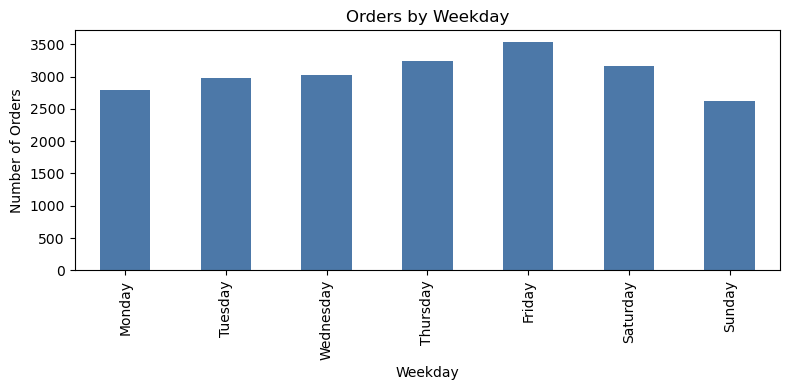

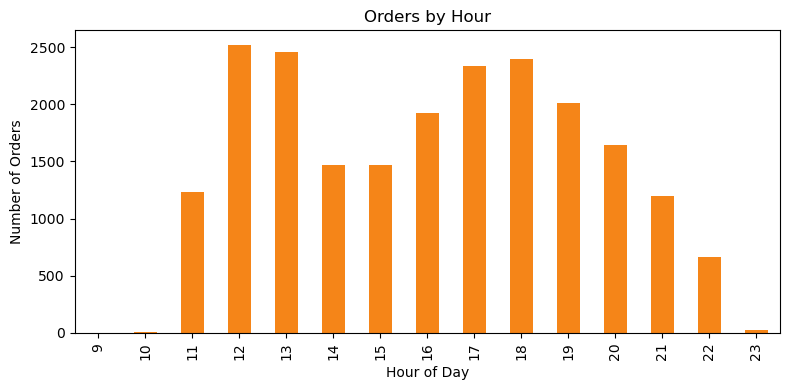

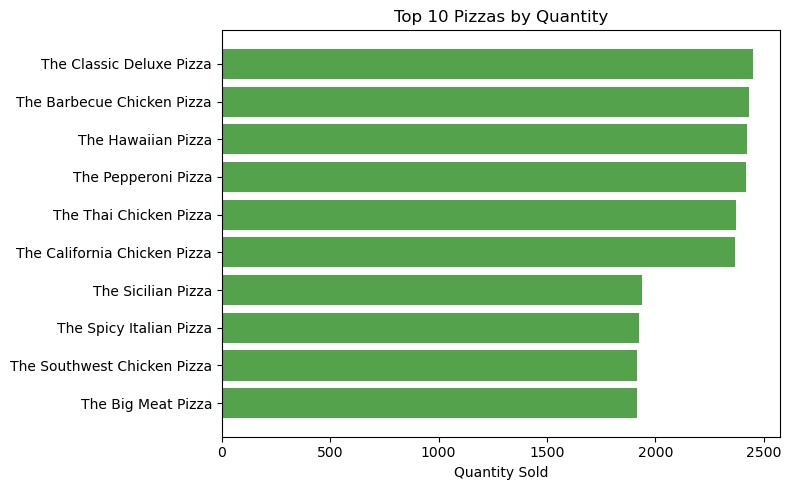

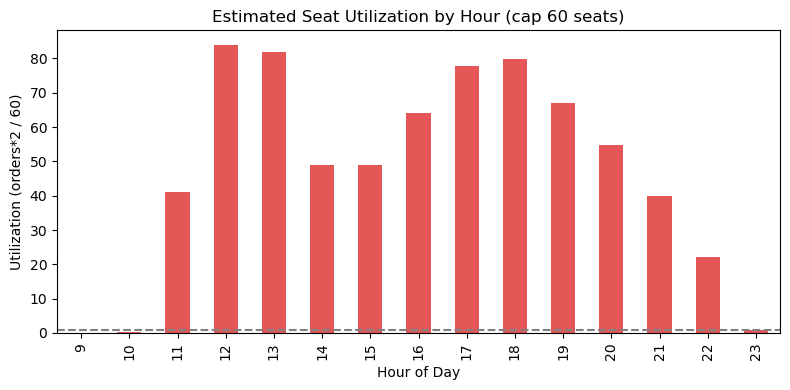

Loaded data, created features, computed KPIs, and rendered 4 visuals.


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load
csv_path = 'D:/Downloads/Data Model - Pizza Sales.xlsx - pizza_sales (1).csv'
df_pizza = pd.read_csv(csv_path, encoding='Windows-1252')

# 2) Basic cleaning and types
df_pizza['order_date'] = pd.to_datetime(df_pizza['order_date'], errors='coerce')
df_pizza['order_time'] = pd.to_datetime(df_pizza['order_time'], format='%H:%M:%S', errors='coerce').dt.time

# remove rows with missing criticals
df_pizza = df_pizza.dropna(subset=['order_id','pizza_id','quantity','unit_price','total_price','order_date'])

# ensure numeric
df_pizza['quantity'] = pd.to_numeric(df_pizza['quantity'], errors='coerce')
df_pizza['unit_price'] = pd.to_numeric(df_pizza['unit_price'], errors='coerce')
df_pizza['total_price'] = pd.to_numeric(df_pizza['total_price'], errors='coerce')

# Helper columns
order_dt = pd.to_datetime(df_pizza['order_date'].astype(str) + ' ' + df_pizza['order_time'].astype(str), errors='coerce')
df_pizza['order_datetime'] = order_dt

df_pizza['hour'] = df_pizza['order_datetime'].dt.hour

df_pizza['weekday'] = df_pizza['order_datetime'].dt.day_name()

df_pizza['date'] = df_pizza['order_datetime'].dt.date

df_pizza['month'] = df_pizza['order_datetime'].dt.to_period('M').astype(str)

# 3) KPIs
# AOV = revenue per order
order_rev = df_pizza.groupby('order_id', as_index=False)['total_price'].sum().rename(columns={'total_price':'order_revenue'})
aov = order_rev['order_revenue'].mean()

# Busiest days (by orders) and times (by hour)
orders_by_day = df_pizza.drop_duplicates(['order_id']).groupby(df_pizza['order_datetime'].dt.day_name()).size().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
orders_by_hour = df_pizza.drop_duplicates(['order_id']).groupby(df_pizza['hour']).size().sort_index()

# Peak period pizza counts (quantity) by hour
qty_by_hour = df_pizza.groupby('hour')['quantity'].sum().sort_values(ascending=False)

# Best and worst selling pizzas by quantity and revenue
sales_by_pizza_qty = df_pizza.groupby('pizza_name', as_index=False)['quantity'].sum().sort_values('quantity', ascending=False)
sales_by_pizza_rev = df_pizza.groupby('pizza_name', as_index=False)['total_price'].sum().sort_values('total_price', ascending=False)

# Seating utilization proxy: estimate guests per order using pizzas as proxy; assume avg 1.5 slices per person with 8 slices per pizza -> persons_per_pizza ~ 8/1.5 ~ 5.33, but that is too high.
# Instead, assume 2 people per order on average as a conservative proxy, then compute hourly seat demand vs 60 seats.
orders_per_hour = df_pizza.drop_duplicates(['order_id','hour']).groupby('hour').size()
estimated_people_per_order = 2.0
seat_capacity = 60
seat_utilization = (orders_per_hour * estimated_people_per_order) / seat_capacity

# 4) Outputs
print(df_pizza.head(10))
print(order_rev.head())
print(round(aov,2))

# Visual 1: Orders by weekday
plt.figure(figsize=(8,4))
orders_by_day.plot(kind='bar', color='#4C78A8')
plt.title('Orders by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Visual 2: Orders by hour
plt.figure(figsize=(8,4))
orders_by_hour.plot(kind='bar', color='#F58518')
plt.title('Orders by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Visual 3: Top 10 pizzas by quantity
plt.figure(figsize=(8,5))
plt.barh(sales_by_pizza_qty.head(10)['pizza_name'][::-1], sales_by_pizza_qty.head(10)['quantity'][::-1], color='#54A24B')
plt.title('Top 10 Pizzas by Quantity')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

# Visual 4: Seat utilization by hour
plt.figure(figsize=(8,4))
seat_utilization.sort_index().plot(kind='bar', color='#E45756')
plt.axhline(1.0, color='gray', linestyle='--')
plt.title('Estimated Seat Utilization by Hour (cap 60 seats)')
plt.xlabel('Hour of Day')
plt.ylabel('Utilization (orders*2 / 60)')
plt.tight_layout()
plt.show()

print('Loaded data, created features, computed KPIs, and rendered 4 visuals.')